In [293]:
import numpy as np
from scipy import fftpack
import base64
import pylab as py
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
#%pylab inline

In [161]:
def readMov(path, frames, height, width, barwidth):
    """
    Reads in a movie chunk form the van Hatteren database.

    Parameters
    ----------
    path  :   string indicating filepath to read from 
    frames:   integer number of frames in the movie
    height:   integer height in pixels of each frame
    width:    integer width in pixels of each frame
    barwidth: integer height of black bar artifact in movie 
    
    Returns
    -------
    d       : numpy matrix with pixel values for movie.
    
    """
    with open(path, 'rb') as fid:
        #read in movie
        d = np.fromfile(fid, np.dtype('uint8'))

    #put data back into a movie shape
    d = np.reshape(d,(frames,height,width))
    #remove black bar from top, and make the other side even too
    d = d[:,barwidth:,int(barwidth/2):-int(barwidth/2)]
    #print(np.shape(d))
    
    return(d)

In [162]:
def fr2ms(frames, fps):
    ms = float(frames)/fps * 1000
    return(ms)

def ms2fr(ms, fps):
    frames = (float(ms)*fps)/1000
    if(frames==0):
        frames=1
    return(int(np.round(frames,decimals=0)))

In [163]:
fpath = '../vanHaterenNaturalMovies/vid075'
fps = 25 #approximated from http://redwood.berkeley.edu/bruno/data/vid075/README and increased by me.
nframes = 9600
rawframeh = 128
rawframew = 128
barw = 16
framew = rawframew - barw #in pixels
frameh = rawframeh - barw #in pixels

#convert to degrees
ppd = 6# pixels per degree subtended on retina (estimated 10deg for 64px in dong atick 95)
framewdeg = framew/ppd 
framehdeg = frameh/ppd
#sampling rate for fft
deltawdeg = 1./ppd
deltahdeg = 1./ppd 
deltathz = 1./fps

#some fun frames:
tree = 1000
zebra = 1822
elephants = 1300
lion = 2600

#read in movie
m = readMov(fpath, nframes, rawframeh, rawframew, barw)

#calc vectorized version
vlen = framew * frameh
vm = np.reshape(m,(nframes,vlen))

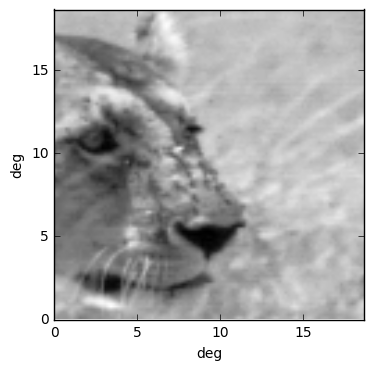

In [164]:
#show a sample image
def getsim(idx):
    sampleim = m[idx,:,:]
    return(sampleim)
    
#plt.imshow(sampleim,cmap='gray') #doesn't look quite as good.
#fig = plt.imshow(getsim(lion),cmap='Greys_r') #this map looks a bit better.

fig, ax = plt.subplots()
ax.imshow(getsim(lion), cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')

In [165]:
## helper functions for animation

##embed animation as html

from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video).decode('utf-8')
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML


#function we can call to animate with HTML
def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

#vanilla animation function
def animate(i):
    im.set_array(clip[i,:,:])
    return im,

In [166]:
##play the moive
samplevid = zebra
vidlen = 500

clip = m[samplevid:samplevid+vidlen,:,:]
cliplen = len(clip[:,1,1])

if(1):
    fig = plt.figure()
    im = plt.imshow(clip[0,:,:], cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
    ax.set_xlabel('deg')
    ax.set_ylabel('deg')
    anim = animation.FuncAnimation(fig, animate, frames=range(cliplen), interval=int(100/cliplen), blit=False)
    
display_animation(anim)

In [167]:
# calculate difference (Dong & Atick 1995a, Figure 1)
def cdiff(fstart, dtms):
    """
    Reads in a movie chunk form the van Hatteren database.

    Parameters
    ----------
    fstart: integer frame to start at.
    dtms: integer time in ms. Must be more than 1/framerate*1000
    
    Returns
    -------
    diffim : numpy matrix with pixel values for dif between frames.
    
    """

    ##ensure dt is more than 1 frame
    if(dtms < fr2ms(1, fps)):
        raise Exception('dt must be greater than one frame! 1 frame is', fr2ms(1,fps))
    #time separation in frames
    df = ms2fr(dtms, fps)
    diff = abs(m[fstart,:,:].astype(int) - m[fstart+df,:,:].astype(int))
    return(diff)

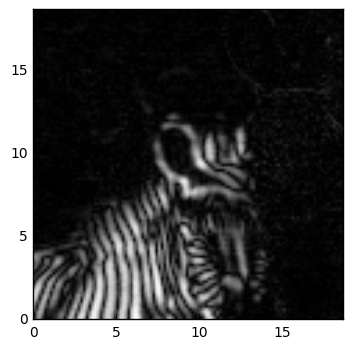

In [168]:
diffim = cdiff(zebra, 40)
plt.imshow(diffim,cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')

## Cross Correlation

In [169]:
#average over all pixles
# calculate cross correlation (Dong & Atick 1995a)

##time separation in miliseconds at 25 fps min separation is 40ms.
dtms = 100
#time separation in frames
df = int(dtms * fps  /1000)
j = lion
onecc = np.corrcoef(vm[j,:], vm[j+df,:])
print(onecc)

[[ 1.          0.94216665]
 [ 0.94216665  1.        ]]


## Spatial Fourier Transform of One Raw Image

In [275]:
# from https://code.google.com/archive/p/agpy/downloads
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr
    radial_prof = radial_prof[:np.floor(framew/2)]

    return radial_prof

In [276]:
def spatialft(image):
    # adpated from http://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/
    # Take the fourier transform of the image.
    F1 = np.fft.fft2(image)
    # Now shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    F2 = np.fft.fftshift(F1)
    
    #get the sampling rate
    freq2D = np.fft.fftfreq(framew, d=1./ppd)

    # Calculate the 2D amplitude & Power Spectrum
    amp2D = np.abs(F2) #magnitude = amplitude of real & imaginary component vector
    psf2D = np.abs(F2)**2 #power specrum = amplitude^2

    ##average over all orientations
    amp1D = azimuthalAverage(amp2D)
    psf1D = azimuthalAverage(psf2D)

    #get the sampling rate
    freq1D = np.fft.fftfreq(int(np.floor(frameh/2)), d=1./ppd)

    return(image, amp2D, psf2D, freq2D, amp1D, psf1D, freq1D)

/home/vasha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


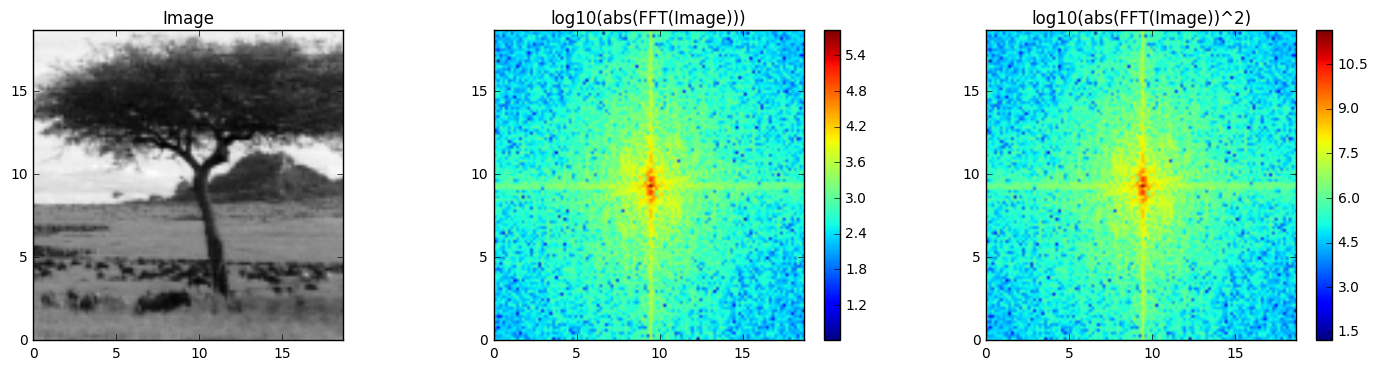

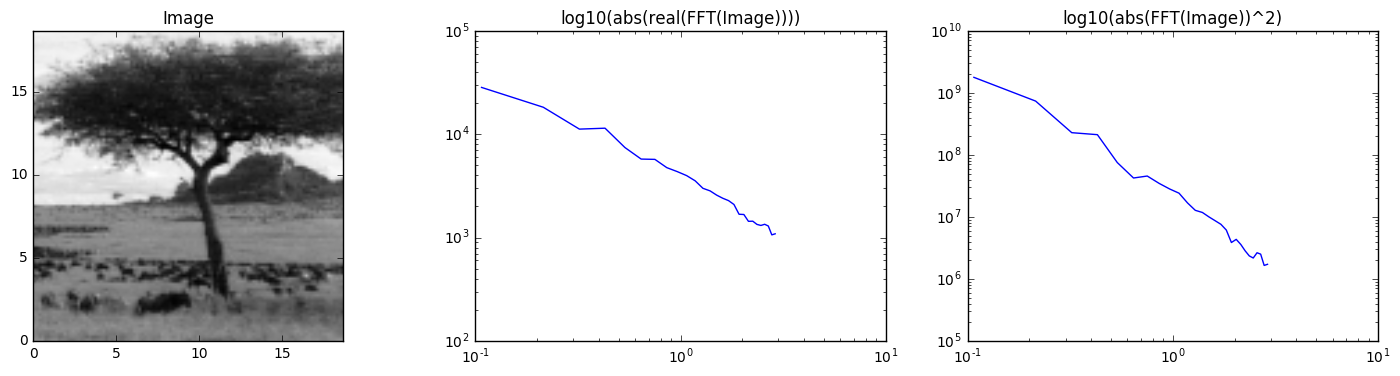

In [277]:
image, amp2D, psf2D, freq2D, amp1D, psf1D, freq1D = spatialft(getsim(tree))
    
##plotting
#2d power spectra
plt.figure(figsize=(18, 4))

plt.subplot(1,3,1,title='Image')
plt.imshow(image, cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')

plt.subplot(1,3,2,title='log10(abs(FFT(Image)))')
#plt.imshow(amp2D)
plt.imshow(np.log10(amp2D), extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')
plt.colorbar()

plt.subplot(1,3,3,title='log10(abs(FFT(Image))^2)')
#plt.imshow(psf2D)
plt.imshow(np.log10(psf2D), extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')
plt.colorbar()

##azimuthal average
plt.figure(figsize=(18, 4))

plt.subplot(1,3,1,title='Image')
plt.imshow(image, cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')

plt.subplot(1,3,2,title='log10(abs(real(FFT(Image))))')
plt.loglog(freq1D, amp1D)

plt.subplot(1,3,3,title='log10(abs(FFT(Image))^2)')
plt.loglog(freq1D, psf1D)

plt.show()

## Spatial Fourier Transform over Many Images

In [316]:
def avgspatialft(movie):
    # adpated from http://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/
    # Take the fourier transform of the image.

    #take a sample image to determine size for avg vars.
    sim = movie[0,:,:]

    avgasf2D = np.zeros_like(np.abs(np.fft.fft2(sim))**2)
    avgpsf2D = np.zeros_like(np.abs(np.fft.fft2(sim))**2)
    avgasf1D = np.zeros_like(azimuthalAverage(avgpsf2D))
    avgpsf1D = np.zeros_like(azimuthalAverage(avgpsf2D))
    
    for i in range(len(movie[:,0,0])):
        im = movie[i,:,:]
        FT = np.fft.fftshift(np.fft.fft2(im))
        real = np.abs(FT)
        
        
        # Calculate the 2D amplitude & Power Spectrum
        psf2D = real**2 #power specrum = amplitude^2

        ##average over all orientations
        asf1D = azimuthalAverage(real)
        psf1D = azimuthalAverage(psf2D)

        
        avgasf2D +=real
        avgasf1D +=asf1D
        avgpsf2D +=psf2D
        avgpsf1D +=psf1D

    avgasf2D = avgasf2D/len(movie[:,0,0])
    avgasf1D = avgasf1D/len(movie[:,0,0])
    avgpsf2D = avgpsf2D/len(movie[:,0,0])
    avgpsf1D = avgpsf1D/len(movie[:,0,0])
    
    avgrate2D = np.fft.fftfreq(framew, d=1./ppd)
    avgrate1D = np.fft.fftfreq(int(np.floor(frameh/2)), d=1./ppd)
    
    
    return avgasf2D, avgpsf2D, avgrate2D, avgasf1D, avgpsf1D, avgrate1D


In [ ]:
#call the function to calculate all these
a2d, p2d, r2d, a1d, p1d, r1d = avgspatialft(m)

/home/vasha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


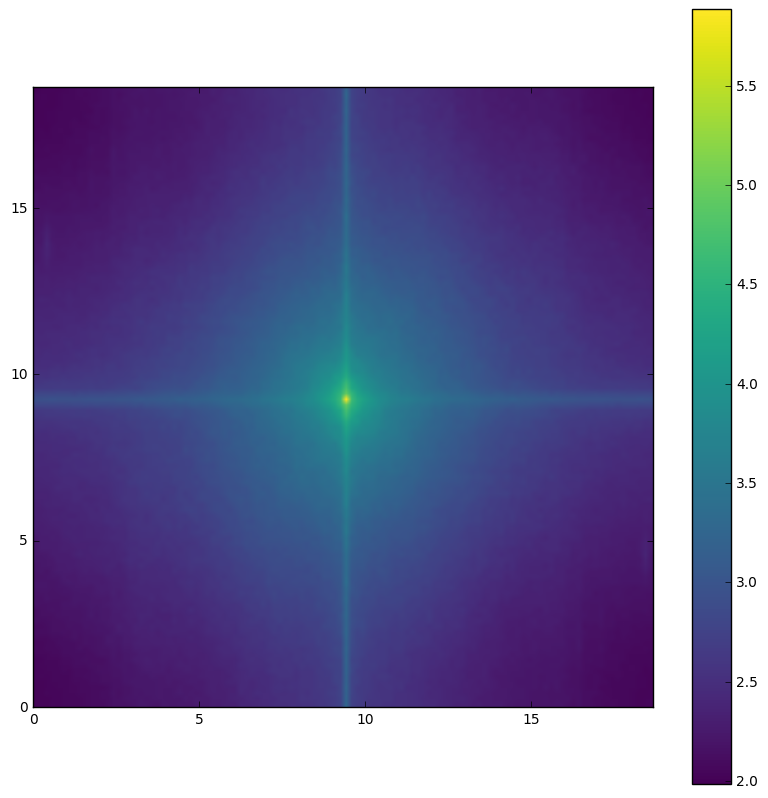

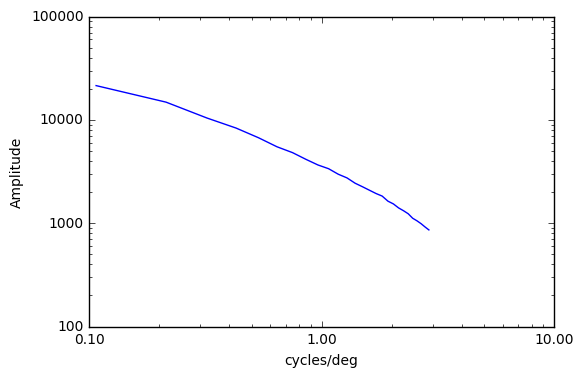

In [317]:
##plotting
#2d amplitude spectrum
plt.figure(figsize=(10,10))
plt.imshow(np.log10(a2d),cmap='viridis', extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')
from matplotlib.ticker import ScalarFormatter
plt.colorbar()

#1d amplitude spectrum
fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(r1d, a1d)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel('cycles/deg')
ax.set_ylabel('Amplitude')


plt.show()

## Average over all images

## Pairwise Probability Distribution (Temporal)

In [282]:
# calculate ppd (Dong & Atick 1995a, Figure 2)
def gettemporalppd(fstart, fend, dtms):
    """
    calculated pairwise probability distribution

    Parameters
    ----------
    fstart: integer frame to start at.
    dtms: integer time in ms. Must be more than 1/framerate*1000
    
    Returns
    -------
    ppd : numpy matrix with pairwise probability distribution.
    
    """
    
    ##ensure dt is more than 1 frame
    if(dtms < fr2ms(1,fps)):
        raise Exception('dt must be greater than one frame! 1 frame is', fr2ms(1,fps))    
    #time separation in frames
    df = ms2fr(dtms, fps)
    
    #levels of light intensity
    lil = 256
    #initialize blank matrix to tally pairs
    ppd = np.zeros((lil,lil))
    #go through all pixels and tally up light intensity pairs
    
    for f in range(fstart,fend-df):
        s1 = vm[f,:]
        s2 = vm[f+df,:]
        for i in range(np.size(s1)):
            ppd[s1[i],s2[i]]+=1
    return(ppd)

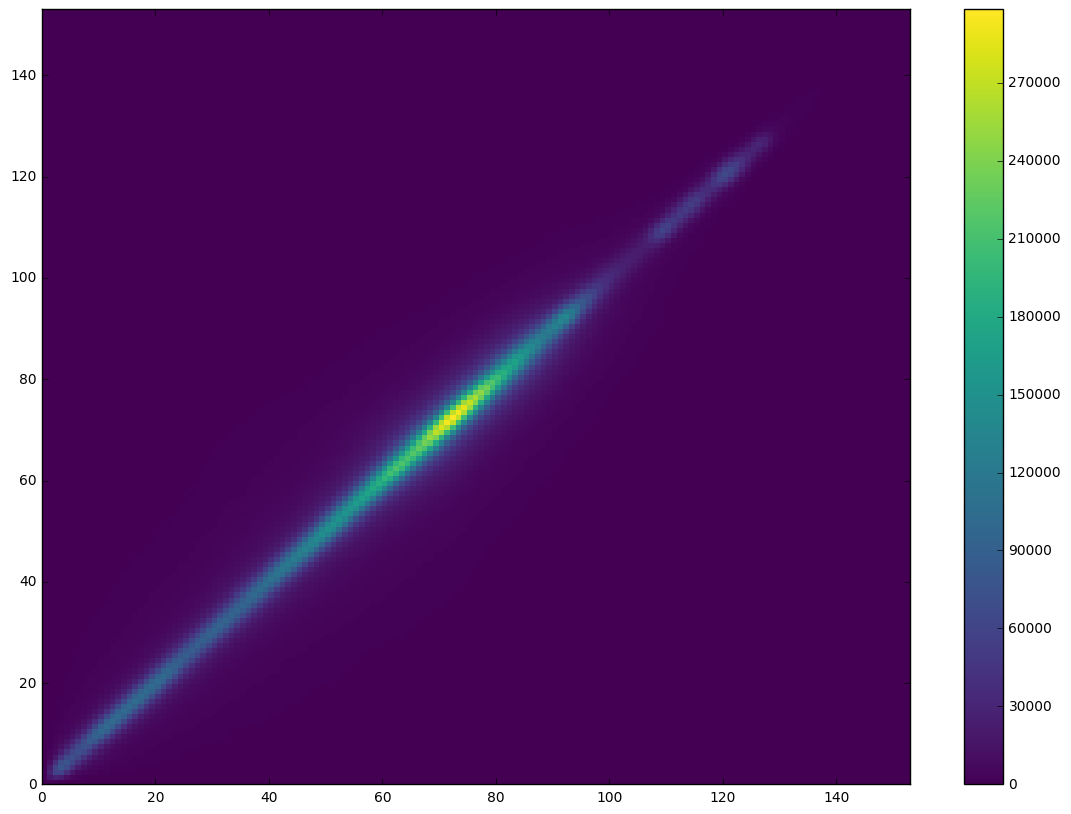

In [283]:
dt = 40*2
myppd = gettemporalppd(0,len(vm),dt)

plt.figure(figsize=(14,10))
plt.pcolormesh(myppd,cmap='viridis')
plt.xlim(0,153)
plt.ylim(0,153)
plt.colorbar()

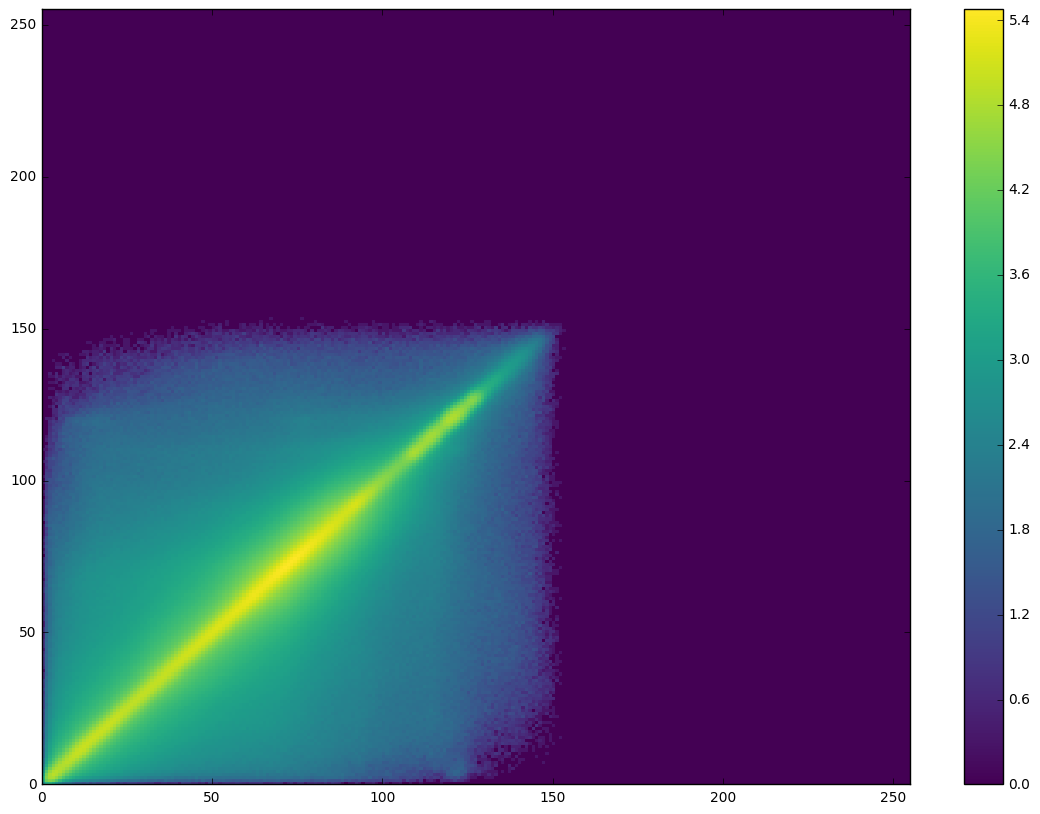

In [284]:
mylppd = np.log10(myppd+1)
plt.figure(figsize=(14,10))
plt.pcolormesh(mylppd,cmap='viridis')
plt.xlim(0,255)
plt.ylim(0,255)
plt.colorbar()

## Where are the cuts?

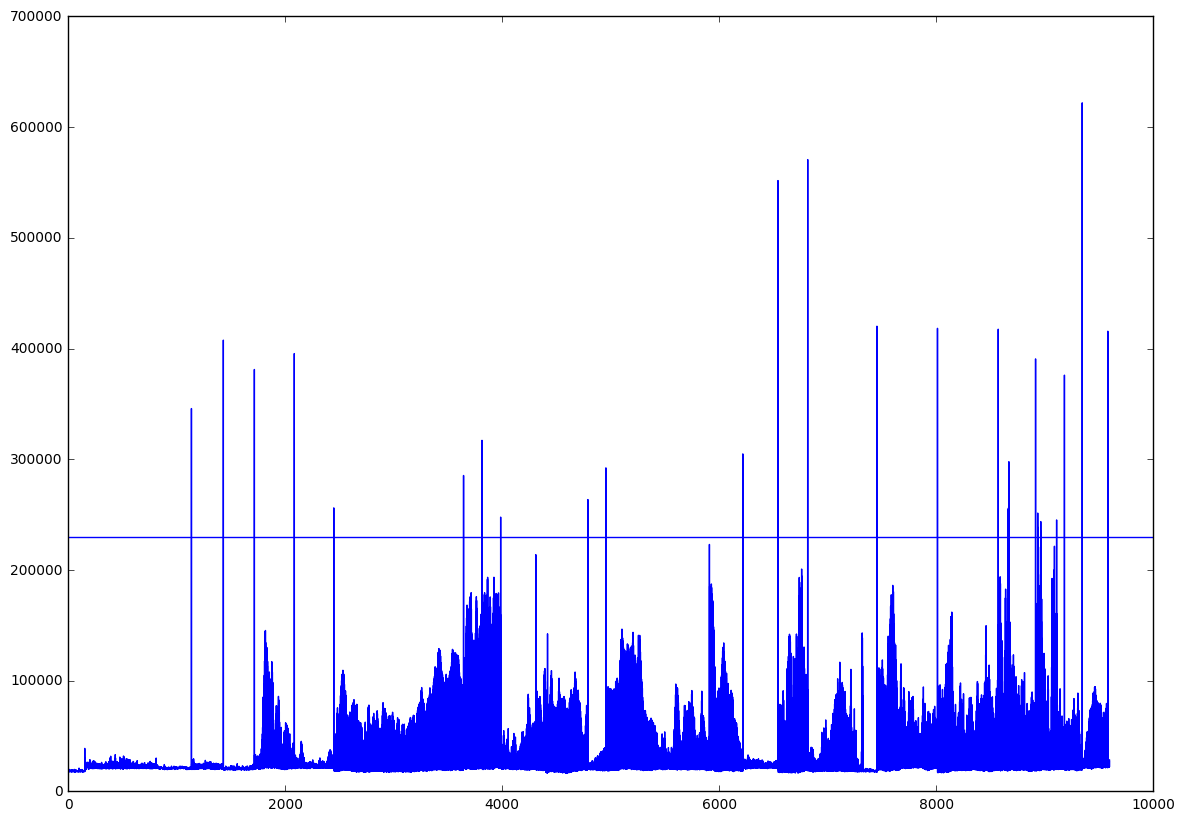

In [285]:
fchange = np.zeros(len(m)-1)
for f in range(len(m)-1):
    fchange[f] = np.sum(cdiff(f, 40))

plt.figure(figsize=(14,10))
plt.plot(fchange)
        
plt.axhline(230000)

## Ignore cuts for now and take 3DFFT

In [288]:
#remove mean so we get rid of dc offset
mm=m-np.mean(m)

stft = np.fft.rfftn(mm,axes=[0]) #time fourier transform
stps = np.abs(stft)**2 #power specrum = amplitude^2

/home/vasha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


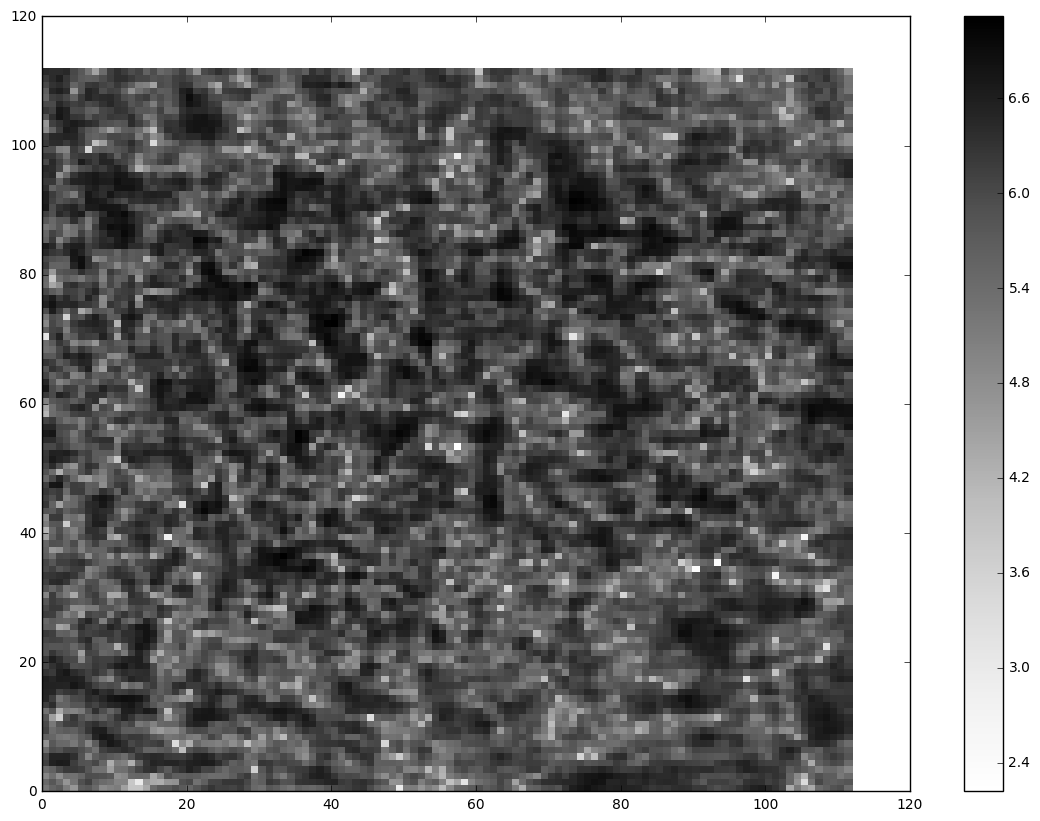

In [292]:
mylppd = np.log10(stps[zebra/2+3,:,:]+1)
plt.figure(figsize=(14,10))
plt.pcolormesh(mylppd,cmap='Greys')
plt.colorbar()

In [23]:
##play the moive
samplevid = 0
vidlen = 1000

#if we don't take the log you can't see much.
clip = np.log10(stps[samplevid:samplevid+vidlen,:,:])
cliplen = len(clip[:,1,1])

if(1):
    fig = plt.figure()
    im = plt.imshow(clip[0,:,:], cmap='Greys_r')
    anim = animation.FuncAnimation(fig, animate, frames=range(cliplen), interval=int(100/cliplen), blit=False)
    
display_animation(anim)
anim.save('temporalfftlog.mp4', fps=fps,bitrate=-1)

In [24]:
tdft = np.fft.fftshift(np.fft.fft2(stft),axes=(1,2))
tdps = np.abs(tdft)**2

In [25]:
def azmmov(threedfft):
    # adpated from http://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/
    # Take the azimuthal average of each frame collapsing x,y (2d) to 1d.

    #take a sample image to determine size for avg vars.
    sim = threedfft[0,:,:]

    avg = np.zeros((np.shape(azimuthalAverage(sim))[0],np.shape(threedfft[:,1,1])[0]))
    
    for i in range(len(threedfft[:,0,0])):

        ##average over all orientations
        psf1D = azimuthalAverage(threedfft[i,:,:])

        avg[:,i] = psf1D

    avg = avg[0:56,:]
    return avg

In [26]:
azavgdtdps = azmmov(tdps)

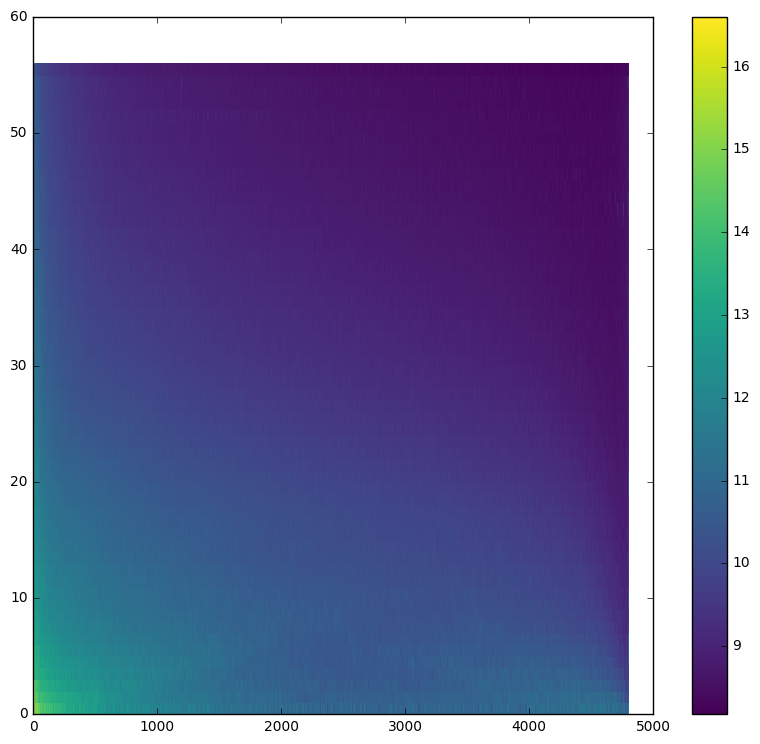

In [32]:
##heatmap
mylppd = np.log10(azavgdtdps)
plt.figure(figsize=(10,9))
#plt.pcolormesh(azavgdtdps)
plt.pcolormesh(mylppd,cmap='viridis')
plt.colorbar()

In [20]:
np.shape(m)

(9600, 112, 112)

In [102]:
# average power over many clips of image

cliplen = 64 #frames
nclips = int(np.floor(len(m)/cliplen))

summedtdft = np.zeros_like(m[0])

for i in range(nclips):
    iclip = m[i*cliplen:(i+1)*cliplen]
    iclip = iclip-np.mean(iclip)
    stft = np.fft.rfftn(iclip,axes=[0]) #time fourier transform
    tdft = np.fft.fftshift(np.fft.fft2(stft),axes=(1,2)) #space
    summedtdft = summedtdft + tdft
    
clpmeandft = summedtdft/nclips
azmeandft= azmmov(clpmeandft)

/home/vasha/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2135: ComplexWarning: Casting complex values to real discards the imaginary part
  return cumsum(axis, dtype, out)


In [103]:
print(nclips)
np.shape(azmeandft)

150


(56, 33)

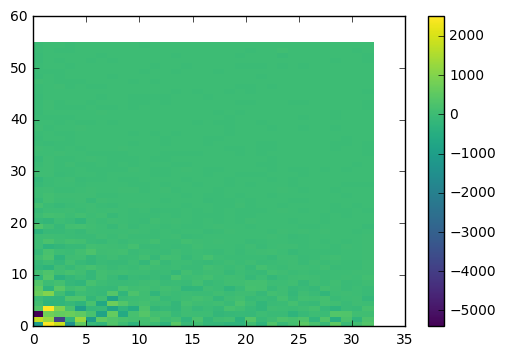

In [104]:
## heatmap
plt.figure()
plt.pcolormesh(azmeandft[1:,1:],cmap='viridis') #remove dc component (0hz) from time and 0 cycles/deg from space
#plt.xscale('log')
#plt.yscale('log')
plt.colorbar()

/home/vasha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


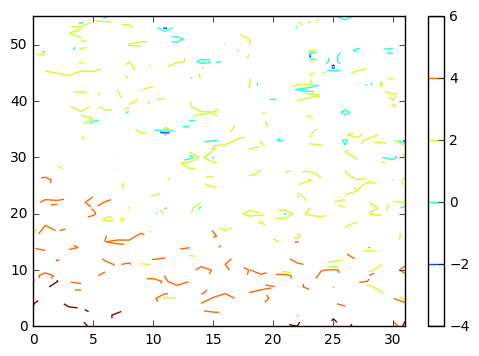

In [105]:
## kelly plot
plt.figure()
plt.contour(np.log(azmeandft[0:,1:]),cmap='jet') #remove dc component (0hz) from time and 0 cycles/deg from space
plt.colorbar()

## Sample from Spatial Frequency Spectrum

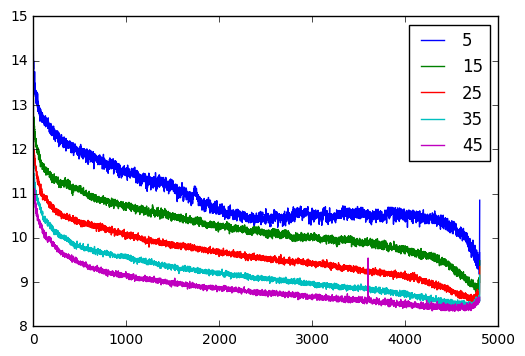

In [29]:
samplefqs = np.arange(5,55,10)

for sf in samplefqs:
    plt.plot(mylppd[sf,:],label=sf)
plt.legend()

## Sample from Temporal Frequency Spectrum

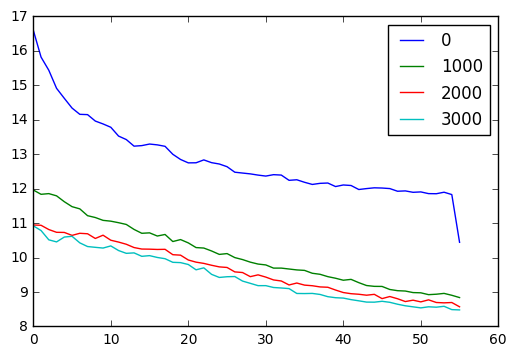

In [30]:
samplefqs = np.arange(0,4000,1000)

for sf in samplefqs:
    plt.plot(mylppd[:,sf],label=sf)
    
plt.legend()


## Meeting with Bruno - Notes to update:  

### Action Items

Change to chunks so the Rayleigh frequency is on the order of something sensible. Right now it's 1 cycle per the entire movie. Averaging over the chunks will also make the data better.

.64 cycles/images max (nuyquist)
0.5 cycles per pixel

Add powers then take sqrt

Discreet fourier transform - Need tapering function on outside of image (use raised cosine)  Do this in time also

Urs' duck movie (ask dyaln for this) might be a better movie than the VH movie.  

For motion sharpening:
Need to figure out the encoding. Also ask Dylan about ffmpeg, this might be a good way to do it.  

Adjust for a DC gain of 1 by ensuring filter sums to 1.  

Coinsider boosting low pass frames

Or blending in high pass filter over time (so we don't just have hole - this may stop the flickering. 